In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


import warnings 
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("train.csv")
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
502,503,20,RL,70.00,9170,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,400,4,2007,WD,Normal,140000
606,607,20,RL,82.00,12464,Pave,NaN,IR2,Low,AllPub,...,0,NaN,GdPrv,NaN,0,11,2009,WD,Normal,152000
661,662,60,RL,52.00,46589,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,402000
1364,1365,160,FV,30.00,3180,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,144152
1334,1335,160,RM,24.00,2368,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,125000


In [3]:
#percentages of missing data in variables
null_percentages = (train.isnull().sum() / len(train["Alley"])) * 100
print((null_percentages[null_percentages>45]))

Alley         93.77
FireplaceQu   47.26
PoolQC        99.52
Fence         80.75
MiscFeature   96.30
dtype: float64


In [4]:
#removal of variables with high missing data
train=train.drop(["Id","Alley","FireplaceQu","PoolQC","Fence","MiscFeature"],axis=1)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.00,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.00,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.00,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.00,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.00,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [5]:
#conversion of categorical variables to numeric with get dummies
train=pd.get_dummies(train)
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.00,8450,7,5,2003,2003,196.00,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.00,9600,6,8,1976,1976,0.00,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.00,11250,7,5,2001,2002,162.00,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.00,9550,7,5,1915,1970,0.00,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.00,14260,8,5,2000,2000,350.00,655,0,...,0,0,0,1,0,0,0,0,1,0


In [6]:
#only variables with high correlation with the independent variable were included
important_num_cols = list(train.corr()["SalePrice"][(train.corr()["SalePrice"]>0.50) | (train.corr()["SalePrice"]<-0.50)].index)
important_num_cols

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'SalePrice',
 'ExterQual_TA',
 'BsmtQual_Ex',
 'KitchenQual_Ex',
 'KitchenQual_TA']

In [7]:
data=train[important_num_cols]
data.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,ExterQual_TA,BsmtQual_Ex,KitchenQual_Ex,KitchenQual_TA
0,7,2003,2003,856,856,1710,2,8,2,548,208500,0,0,0,0
1,6,1976,1976,1262,1262,1262,2,6,2,460,181500,1,0,0,1
2,7,2001,2002,920,920,1786,2,6,2,608,223500,0,0,0,0
3,7,1915,1970,756,961,1717,1,7,3,642,140000,1,0,0,0
4,8,2000,2000,1145,1145,2198,2,9,3,836,250000,0,0,0,0


In [8]:
#highest correlation with independent variable for categorical variables with only one choice
#Added variables that have in the relation
data["ExterQual_Ex"]=train["ExterQual_Ex"]
data["Foundation_CBlock"]=train["Foundation_CBlock"]
data["GarageFinish_Fin"]=train["GarageFinish_Fin"]

data.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,ExterQual_TA,BsmtQual_Ex,KitchenQual_Ex,KitchenQual_TA,ExterQual_Ex,Foundation_CBlock,GarageFinish_Fin
0,7,2003,2003,856,856,1710,2,8,2,548,208500,0,0,0,0,0,0,0
1,6,1976,1976,1262,1262,1262,2,6,2,460,181500,1,0,0,1,0,1,0
2,7,2001,2002,920,920,1786,2,6,2,608,223500,0,0,0,0,0,0,0
3,7,1915,1970,756,961,1717,1,7,3,642,140000,1,0,0,0,0,0,0
4,8,2000,2000,1145,1145,2198,2,9,3,836,250000,0,0,0,0,0,0,0


In [9]:
#detection of missing values
data.isnull().sum()

OverallQual          0
YearBuilt            0
YearRemodAdd         0
TotalBsmtSF          0
1stFlrSF             0
GrLivArea            0
FullBath             0
TotRmsAbvGrd         0
GarageCars           0
GarageArea           0
SalePrice            0
ExterQual_TA         0
BsmtQual_Ex          0
KitchenQual_Ex       0
KitchenQual_TA       0
ExterQual_Ex         0
Foundation_CBlock    0
GarageFinish_Fin     0
dtype: int64

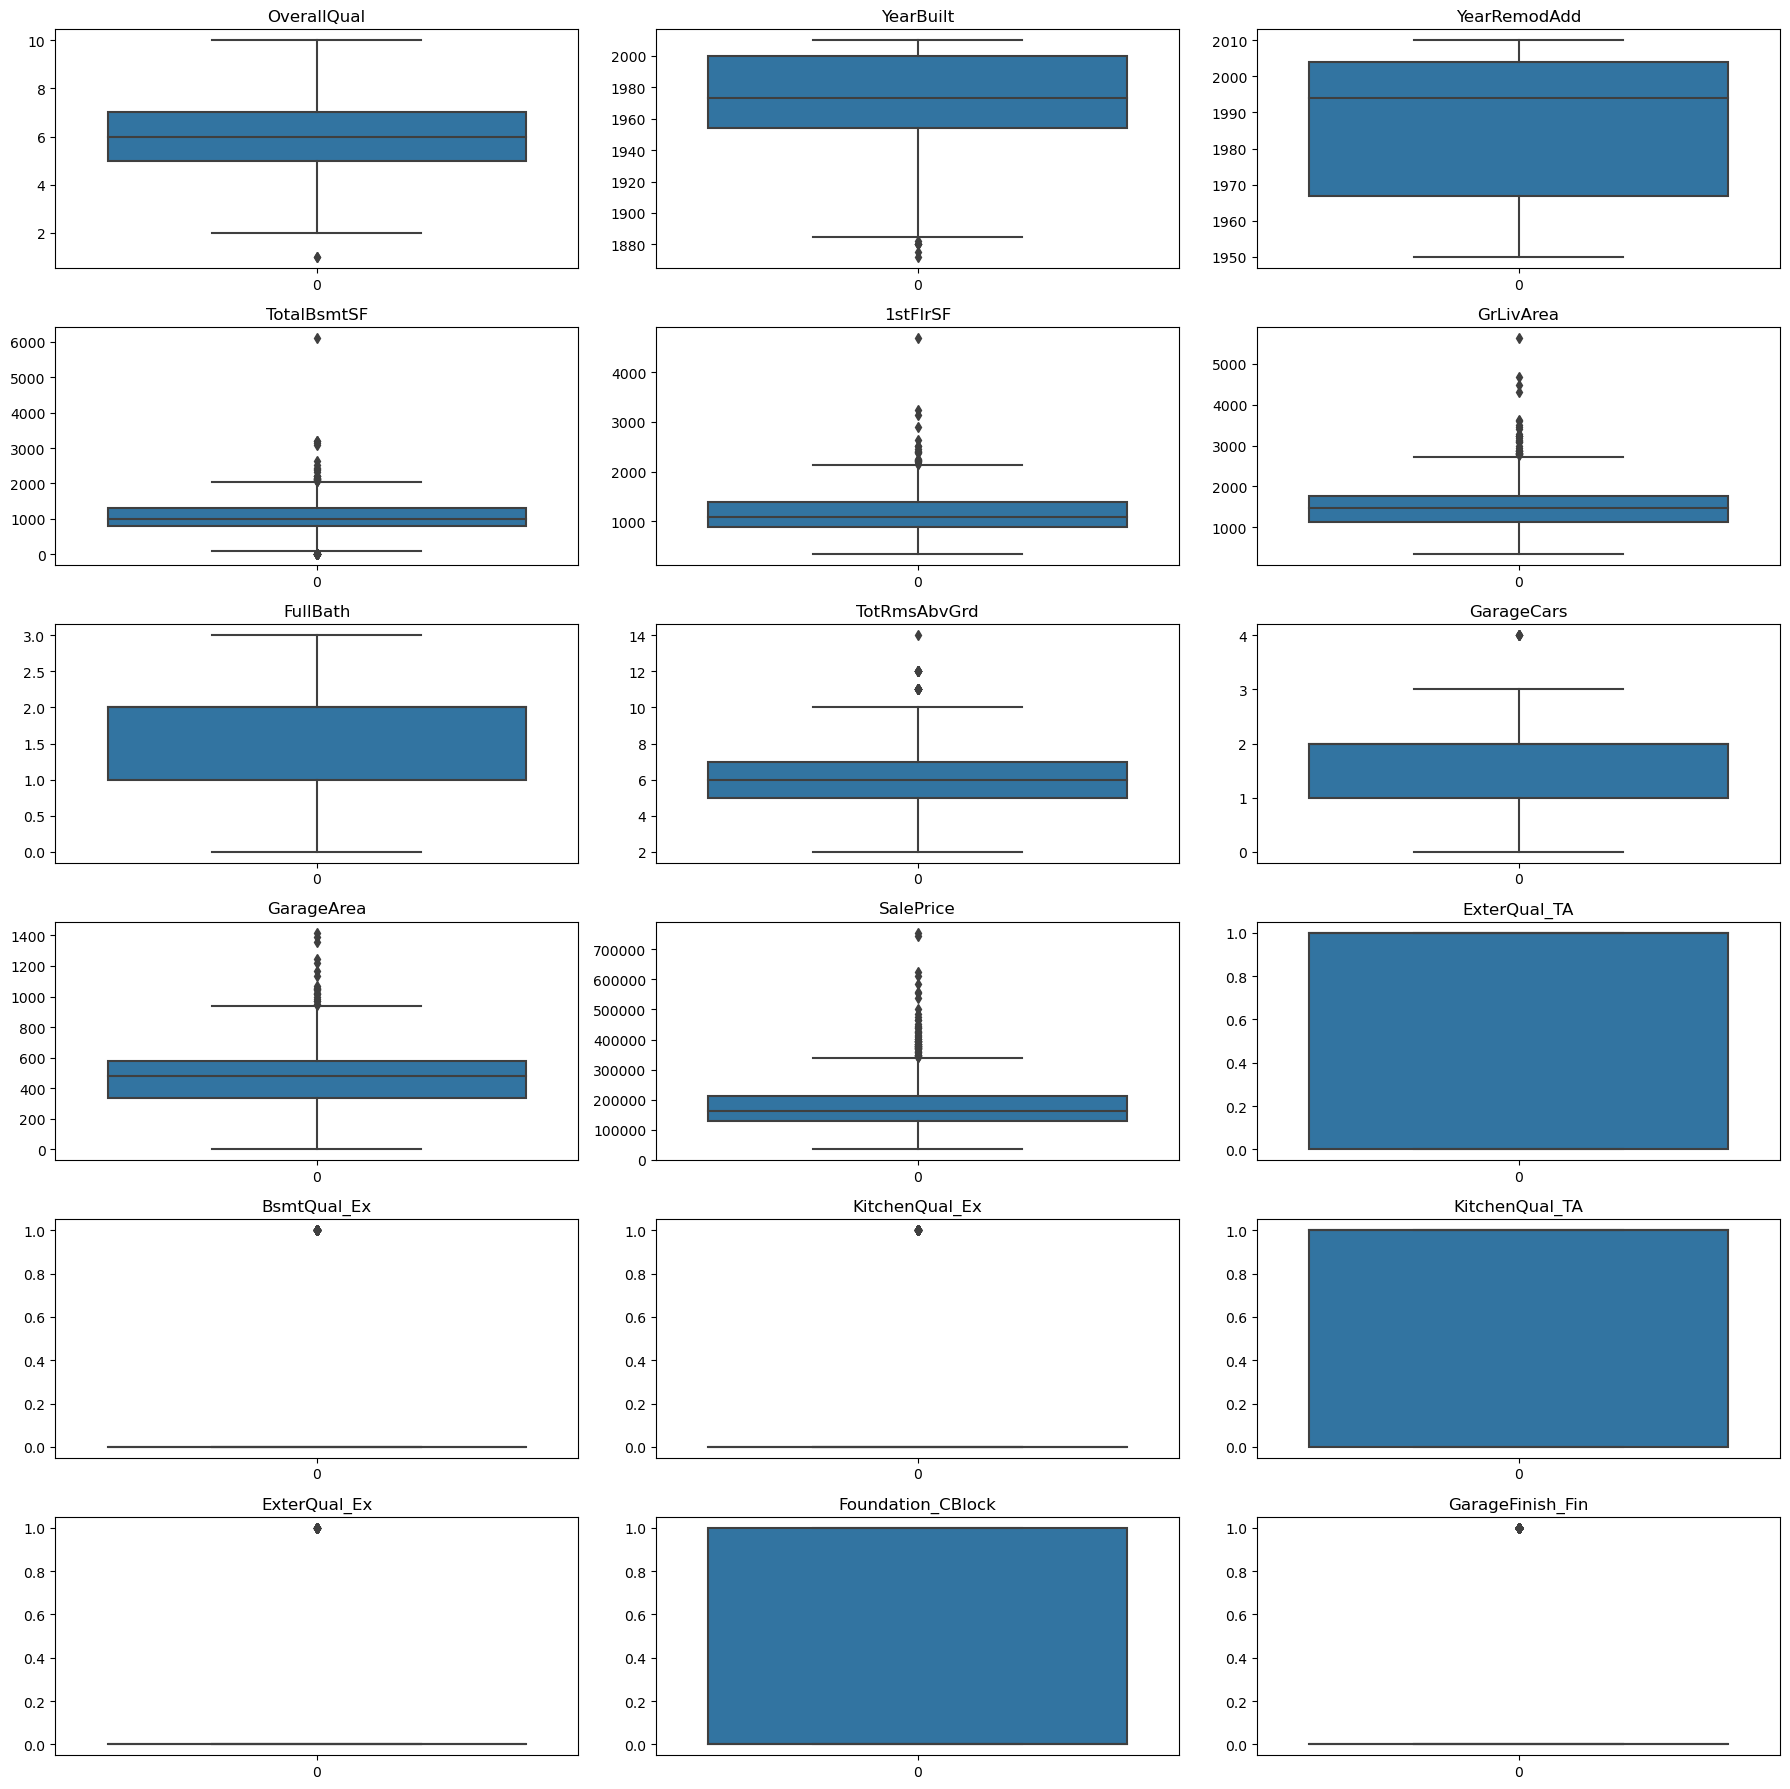

In [10]:
#detection of outliers
import seaborn as sns 
import matplotlib.pyplot as plt

columns = data.columns
fig, axes = plt.subplots(6, 3, figsize=(18, 18))
axes = axes.ravel() # alt-çizimleri düzleştirin

for i, column in enumerate(columns):
    sns.boxplot(data[column], ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()
plt.show()


In [11]:
#Identification of columns with outliers
oulier_columns=["TotalBsmtSF","1stFlrSF","GrLivArea","TotRmsAbvGrd",
                          "GarageCars","GarageArea","SalePrice"]

In [12]:
# suppression of outliers:
def outlier(datas):
    Q1=datas.quantile(0.25)
    Q3=datas.quantile(0.75)
    IQR=Q3-Q1
    lower_limit=Q1-1.5*IQR
    upper_limit=Q3+1.5*IQR
    list_=[]
    for data in datas:
        if(data<lower_limit):
            list_.append(lower_limit)
        elif(data>upper_limit):
            list_.append(upper_limit)
        else:
            list_.append(data)
    return list_

In [13]:
for i in oulier_columns:
    data[i]=pd.DataFrame(outlier(data[i]))

In [14]:
data.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,ExterQual_TA,BsmtQual_Ex,KitchenQual_Ex,KitchenQual_TA,ExterQual_Ex,Foundation_CBlock,GarageFinish_Fin
0,7,2003,2003,856.00,856.00,1710.00,2,8.00,2.00,548.00,208500.00,0,0,0,0,0,0,0
1,6,1976,1976,1262.00,1262.00,1262.00,2,6.00,2.00,460.00,181500.00,1,0,0,1,0,1,0
2,7,2001,2002,920.00,920.00,1786.00,2,6.00,2.00,608.00,223500.00,0,0,0,0,0,0,0
3,7,1915,1970,756.00,961.00,1717.00,1,7.00,3.00,642.00,140000.00,1,0,0,0,0,0,0
4,8,2000,2000,1145.00,1145.00,2198.00,2,9.00,3.00,836.00,250000.00,0,0,0,0,0,0,0


In [15]:
data.to_csv("cleaning_data.csv")